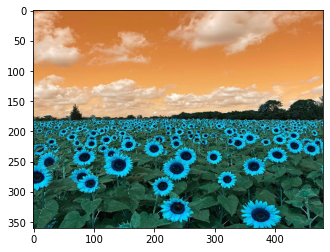

In [48]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("./the_berry_farms_sunflower_field (1).jpeg",1)
img = cv2.resize(img, (480, 360))
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0
imshow(img,cmap="gray")

In [34]:
def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) * (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [35]:
def LoG_convolve(img):
    log_images = []
    for i in range(0,9):
        y = np.power(k,i)
        sigma_1 = sigma*y
        filter_log = LoG(sigma_1)
        image = cv2.filter2D(img,-1,filter_log)
        image = np.pad(image,((1,1),(1,1)),'constant')
        image = np.square(image)
        log_images.append(image)
    log_image_np = np.array([i for i in log_images])
    return log_image_np
log_image_np = LoG_convolve(img)
print(log_image_np.shape)

(9, 362, 482)


In [36]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))
    
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0

    return np.array([b for b in blobs_array if b[-1] > 0])

In [37]:
def detect_blob(log_image_np):
    co_ordinates = []
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2]
            result = np.amax(slice_img)
            #result_1 = np.amin(slice_img)
            if result >= 0.03:
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma))
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

In [ ]:
for circle in co_ordinates:
    center_x, center_y, radius = circle
    cv.circle(img, (int(center_y), int(center_x)), int(radius), (0, 0, 255), 2)  # Draw the circle

# Display the image with circles
cv.imshow("Circles Detected", img)
cv.waitKey(0)
cv.destroyAllWindows()

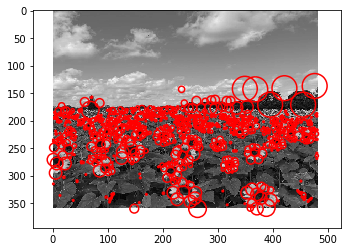

In [42]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0

ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()